<img src="Electronic_Brain.png" width="200" style="float:left">
<h1> Summer 2021 ML Course.</h1>
<h2> Exercise 12: Time Series<br>Tools: Sktime</h2>

In [1]:
!python --version
import numpy as np
import pandas as pd

import matplotlib as plt
import matplotlib.pyplot as plt

from scipy.linalg import norm
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import MiniRocket, MiniRocketMultivariate
from random import gauss, randint
from icecream import ic

Python 3.8.6


In [2]:
# Set a few defaults.
# np.random.seed(666)
np.random.seed()
pd.set_option('display.precision', 3)
plt.rcParams['figure.figsize'] = [15, 5]

<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section A: Stationary Signals with Different Variance</h1>
We begin our time series quest with a simple example: two stationary zero-mean signals with a slightly different variances.<br>
Calling the two signals AAPL and MSFT, we randomly generate 500 signal segments, of length 200 each.<br>
We use half for training, half for testing.

In [3]:
# Generate AAPL's "stationary" behavior, with variance 3 (as compared to MSFT's 2.5).
num_subseqs = 500
series_len = 200
prices_df = pd.DataFrame()
appl_prices = np.array([])
msft_prices = np.array([])
ticker_idx = {'AAPL':0, 'MSFT':1}
ticker_sigmas = {'AAPL':3, 'MSFT':2.5}

tickers = []
X = np.zeros([2*num_subseqs, series_len])
idx = 0
for _ in range(num_subseqs):
    for ticker in ['AAPL', 'MSFT']:
        X[idx, :] = np.random.normal(0, ticker_sigmas[ticker], series_len)
        tickers.append(ticker_idx[ticker])
        idx += 1
    
X_train = from_2d_array_to_nested(X[:499, :])
y_train = pd.DataFrame(tickers[:499], columns=['class_val'])
X_test = from_2d_array_to_nested(X[500:, :])
y_test = pd.DataFrame(tickers[500:], columns=['class_val'])
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
ic(X_train.shape, y_train.shape)
ic(X_test.shape, y_test.shape);

ic| X_train.shape: (499, 1), y_train.shape: (499,)
ic| X_test.shape: (500, 1), y_test.shape: (500,)


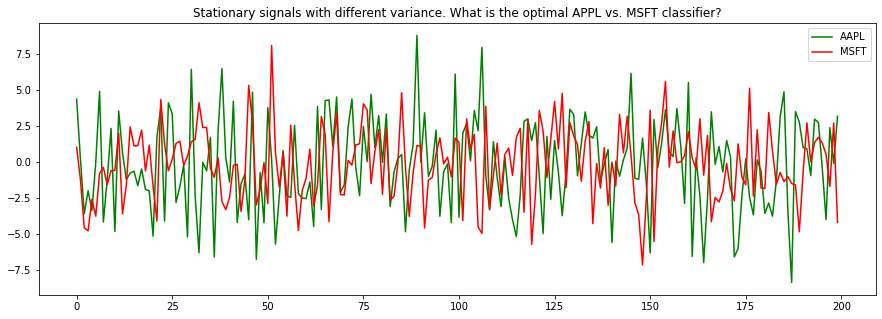

In [4]:
AAPL = X_train[0].iloc[0].values
MSFT = X_train[0].iloc[1].values

fig, ax = plt.subplots()
ax.plot(AAPL, color='green', label='AAPL')
ax.plot(MSFT, color='red', label='MSFT')
ax.set_title('Stationary signals with different variance. What is the optimal APPL vs. MSFT classifier?')
ax.legend();

<img src="rice.png" width="80" style="float:left">
We first use Rice's (optimal) variance estimator to classify the series.<br>
After estimating the variance numerically we set the midpoint of the (known) variances as the threshold.

In [5]:
num_correct_class = 0
for i in range(len(y_test)):
    series_std = np.sqrt(np.var(X[i,:]))
    series_class = i%2

    # Use 2.75 as the threshold (midpoint between 2.5 and 3).
    if (series_std > 2.75 and series_class==0) or (series_std < 2.75 and series_class==1):
        num_correct_class += 1

correct_pct_str = "{:.2f}".format(100*num_correct_class / len(y_test))
print("Rice estimator correct classifications:", num_correct_class, "out of", len(y_test), "(", correct_pct_str, "%)")

Rice estimator correct classifications: 477 out of 500 ( 95.40 %)


<img src="rocket-ship.png" width="60" style="float:left">
<br>We now use the MiniROCKET classifier for the exact same task.

In [6]:
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)

In [7]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train);

In [8]:
X_test_transform = minirocket.transform(X_test)

In [9]:
mini_rocket_score = classifier.score(X_test_transform, y_test)
correct_pct_str = "{:.2f}".format(100*mini_rocket_score)
print("MiniRocket classification accuracy:", correct_pct_str, "%")

MiniRocket classification accuracy: 95.80 %


<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section B: Switching signals</h1><br>
We now generate some "new norm" behavior: prices alternating between levels of 10 and 30 USD, for 20 days at a time.<br>
Aside from the "price transition", AAPL and MSFT have variances identical to the previous section.

In [10]:
# Generate the "Alternating" behavior. 
num_subseqs = 500
num_cycles = 10
cycle_len = 20
padding_len = 30
final_len = num_cycles * cycle_len + padding_len

prices_df = pd.DataFrame()
appl_prices = np.array([])
msft_prices = np.array([])
ticker_idx = {'AAPL':0, 'MSFT':1}
ticker_sigmas = {'AAPL':3, 'MSFT':2.5}

tickers = []
X = np.zeros([2*num_subseqs, final_len])
idx = 0
for _ in range(num_subseqs):
    for ticker in ['AAPL', 'MSFT']:
       
        prices = np.array([])
        for i in range(num_cycles):
            curr_prices = 20 + 10*(-1)**i + np.random.normal(0, ticker_sigmas[ticker], cycle_len)
            prices = np.append(prices, curr_prices)
        
        # Add a random number of prefix & suffix zeros such that the sum remains constant.
        prefix_len = np.random.randint(padding_len)
        prefix_pad = np.zeros(prefix_len)
        suffix_pad = np.zeros(padding_len - prefix_len)
        final_prices = np.concatenate((prefix_pad, prices, suffix_pad))

        X[idx, :] = final_prices
        tickers.append(ticker_idx[ticker])
        idx += 1
    
X_train = from_2d_array_to_nested(X[:499, :])
y_train = pd.DataFrame(tickers[:499], columns=['class_val'])
X_test = from_2d_array_to_nested(X[500:, :])
y_test = pd.DataFrame(tickers[500:], columns=['class_val'])
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
ic(X_train.shape, y_train.shape)
ic(X_test.shape, y_test.shape);

ic| X_train.shape: (499, 1), y_train.shape: (499,)
ic| X_test.shape: (500, 1), y_test.shape: (500,)


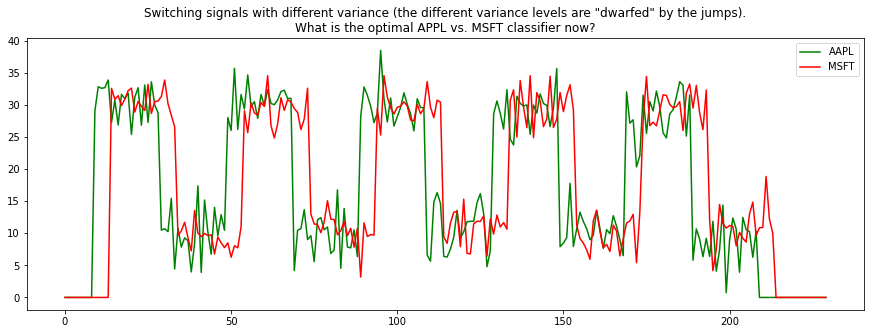

In [11]:
AAPL = X_train[0].iloc[0].values
MSFT = X_train[0].iloc[1].values

fig, ax = plt.subplots()
ax.plot(AAPL, color='green', label='AAPL')
ax.plot(MSFT, color='red', label='MSFT')
ax.set_title('Switching signals with different variance (the different variance levels are "dwarfed" by the jumps).\n' + \
             'What is the optimal APPL vs. MSFT classifier now?')
ax.legend();

In [12]:
# Use Rice's (not-optimal-anymore) variance estimator to classify the series.
correct_class = 0
threshold = 11.7825  # This number was optimized manually!
for i in range(len(y_test)):
    series_std = np.sqrt(np.var(X[i,:]))
    series_class = i%2
    #print(series_class, series_std)
    if (series_std > threshold and series_class==0) or (series_std < threshold and series_class==1):
        correct_class += 1

correct_pct_str = "{:.2f}".format(100*correct_class / len(y_test))
print("Number of correct classifications:", correct_class, "out of", len(y_test), "(", correct_pct_str, "%)")

Number of correct classifications: 312 out of 500 ( 62.40 %)


<img src="rocket-ship.png" width="60" style="float:left">
<br>We now use the MiniROCKET classifier for the exact same task.

In [13]:
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)

In [14]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train);

In [15]:
X_test_transform = minirocket.transform(X_test)

In [16]:
mini_rocket_score = classifier.score(X_test_transform, y_test)
correct_pct_str = "{:.2f}".format(100*mini_rocket_score)
print("MiniRocket classification accuracy:", correct_pct_str, "%")

# BTW, if we wish to obtain the actual decisions per sample, they are avail via:
dec_func = classifier.decision_function(X_train_transform)

MiniRocket classification accuracy: 94.80 %


<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section C: Transitioning signals</h1>
We generate stock prices yet again, this time *transitioning* from one price level to another.<br>
The transitions occur at random locations, with AAPL transitioning somewhere in the first half of the series, while MSFT transitions in the second.<br>
In order to challenge the classifier,we now set the two stocks' variances identically.

In [17]:
price_sigma = 3
series_len = 200

prices_df = pd.DataFrame()
appl_prices = np.array([])
msft_prices = np.array([])

ticker_idx = {'AAPL':0, 'MSFT':1}
ticker_sigmas = {'AAPL':price_sigma, 'MSFT':price_sigma}

tickers = []
X = np.zeros([2*num_subseqs, series_len])
idx = 0
for _ in range(num_subseqs):
    for ticker in ['AAPL', 'MSFT']:
        X[idx, :] = np.random.normal(0, ticker_sigmas[ticker], series_len)
        tickers.append(ticker_idx[ticker])
        
        # AAPL always transitions at a random time during the first half of the series while
        # MSFT transitions during the second half.
        transition_idx = np.random.randint(series_len//2)
        if ticker=='MSFT':
            transition_idx += series_len//2
        
        X[idx, transition_idx:] += price_sigma # Add one price sigma only after the transition.
        idx += 1    

X_train = from_2d_array_to_nested(X[:499, :])
y_train = pd.DataFrame(tickers[:499], columns=['class_val'])
X_test = from_2d_array_to_nested(X[500:, :])
y_test = pd.DataFrame(tickers[500:], columns=['class_val'])
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
ic(X_train.shape, y_train.shape)
ic(X_test.shape, y_test.shape);

ic| X_train.shape: (499, 1), y_train.shape: (499,)
ic| X_test.shape: (500, 1), y_test.shape: (500,)


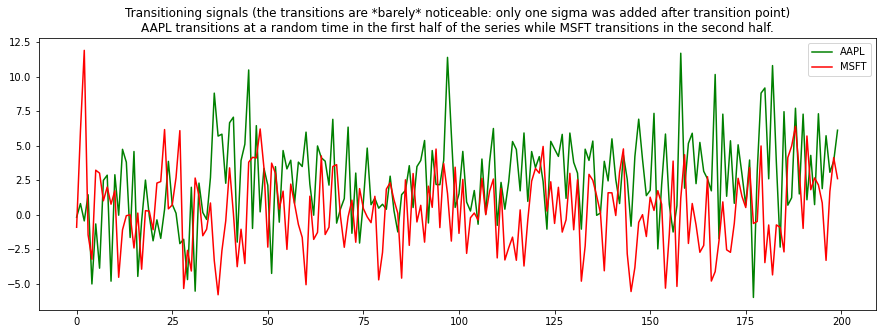

In [18]:
AAPL = X_train[0].iloc[0].values
MSFT = X_train[0].iloc[1].values

fig, ax = plt.subplots()
ax.plot(AAPL, color='green', label='AAPL')
ax.plot(MSFT, color='red', label='MSFT')
ax.set_title('Transitioning signals (the transitions are *barely* noticeable: only one sigma was added after transition point)\n' + \
    'AAPL transitions at a random time in the first half of the series while MSFT transitions in the second half.')
ax.legend();

In [19]:
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)

In [20]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train);

In [21]:
X_test_transform = minirocket.transform(X_test)

In [22]:
mini_rocket_score = classifier.score(X_test_transform, y_test)
correct_pct_str = "{:.2f}".format(100*mini_rocket_score)
print("MiniRocket classification accuracy:", correct_pct_str, "%")

MiniRocket classification accuracy: 97.20 %


<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section D: Multipath Signal Classification</h1><br>
Compose signals via random sinusoids, with relatively low (<< Nyquist) frequencies.<br>
Add delayed signals only to the first class.

In [23]:
num_sigs_each_class = 500
num_sines_per_signal = 3

samp_freq = 500
min_sine_freq = 10
max_sine_freq = 50

min_delay = 0.0025
max_delay = 0.005
simulation_secs = 10
delayed_amp = 0.1

basic_sig_comb = np.arange(0, simulation_secs, 1/samp_freq)
X = np.zeros([2*num_sigs_each_class, len(basic_sig_comb)])

labels = []
idx = 0
for _ in range(num_sigs_each_class):
    for sig_class in [0,1]:
        sig_comb = np.random.rand() + basic_sig_comb # Offset signal comb by some random number (why not?).
        
        # Generate the signal via randomly selected sine freqs.
        sine_freqs = min_sine_freq + (max_sine_freq - min_sine_freq) * np.random.rand(num_sines_per_signal)
        sig = np.zeros(len(basic_sig_comb))
        for freq in sine_freqs:
            sig += np.cos(2*np.pi*freq*sig_comb)

        if sig_class==1:
            # Choose a random delay randomly from 0 to max_delay.
            delay = min_delay + (max_delay - min_delay) * np.random.rand()
            delayed_comb = sig_comb + delay
            for freq in sine_freqs:
                sig += delayed_amp * np.cos(2*np.pi*freq*delayed_comb)
        
        labels.append(sig_class)
        # The correct version of "stating" the problem: normalizing the signal (we don't want the algorithm to cheat!).
        # X[idx, :] = sig / np.linalg.norm(sig)
        
        X[idx, :] = sig # The version to be presented in the actual exercise...
        idx += 1
    
X_train = from_2d_array_to_nested(X[:499, :])
y_train = pd.DataFrame(labels[:499], columns=['class_val'])
X_test = from_2d_array_to_nested(X[500:, :])
y_test = pd.DataFrame(labels[500:], columns=['class_val'])
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
ic(X_train.shape, y_train.shape)
ic(X_test.shape, y_test.shape);

ic| X_train.shape: (499, 1), y_train.shape: (499,)
ic| X_test.shape: (500, 1), y_test.shape: (500,)


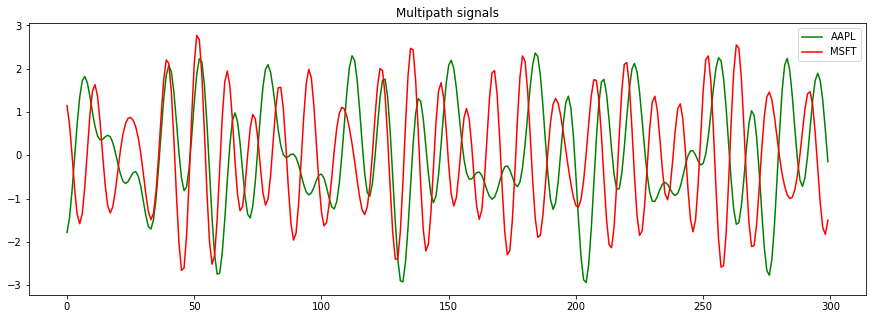

In [24]:
AAPL = X_train[0].iloc[0].values
MSFT = X_train[0].iloc[1].values

fig, ax = plt.subplots()
ax.plot(AAPL[:300], color='green', label='AAPL')
ax.plot(MSFT[:300], color='red', label='MSFT')
ax.set_title('Multipath signals')
ax.legend();

In [25]:
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)

classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train);

In [26]:
X_test_transform = minirocket.transform(X_test)

In [27]:
mini_rocket_score = classifier.score(X_test_transform, y_test)
correct_pct_str = "{:.2f}".format(100*mini_rocket_score)
print("MiniRocket classification accuracy:", correct_pct_str, "%")

MiniRocket classification accuracy: 97.80 %


<img src="Electronic_Brain.png" width="120" style="float:left">
Which physical feature in the time series did the algorithm use to perform the classification?<br>
Please test your hypothesis via simulation.

<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Section E: Sinusoidal Frequency Estimation</h1>

In [33]:
# Compose a signals with one random frequency (< Nyquist) sinusoid plus noise.
num_sigs = 1000
noise_amp = 0.1
samp_freq = 500
simulation_secs = 4
min_sine_freq = 1
max_sine_freq = 249

# Set up a "basic" sample comb, which each signal will move by some delay.
basic_sig_comb = np.arange(0, simulation_secs, 1/samp_freq)
sig_len = len(basic_sig_comb)

X = np.zeros([num_sigs, sig_len])
y = np.zeros(num_sigs)
for idx in range(num_sigs):
    
    # Offset sample comb by some random number (== phase).
    sig_comb = np.random.rand() + basic_sig_comb  
    # Generate the signal via a random frequency sine wave.
    sine_freq = min_sine_freq + np.random.rand() * (max_sine_freq - min_sine_freq)
    sig = np.cos(2*np.pi*sine_freq*sig_comb) + noise_amp * np.random.standard_normal(sig_len)

    X[idx, :] = sig
    y[idx] = sine_freq

X_train = from_2d_array_to_nested(X[:499])
y_train = pd.DataFrame(y[:499], columns=['class_val'])

X_test = from_2d_array_to_nested(X[500:])
y_test = pd.DataFrame(y[500:], columns=['class_val'])

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

ic(X.shape)
ic(X_train.shape, y_train.shape)
ic(X_test.shape, y_test.shape);

ic| X.shape: (1000, 2000)
ic| X_train.shape: (499, 1), y_train.shape: (499,)
ic| X_test.shape: (500, 1), y_test.shape: (500,)


In [34]:
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)

regressor = RidgeCV()
regressor.fit(X_train_transform, y_train)

X_test_transform = minirocket.transform(X_test)
reg_score = regressor.score(X_test_transform, y_test)

# Obtain the default score for RidgeCV (see sklearn's documentation for details).
regression_score_str = "{:.3f}".format(reg_score)
print("MiniRocket regression score:", regression_score_str)

# To better understand the regression accuracy we form the error vector, then calculate its mean absolute deviation per sample.
error_vec = y_test - regressor.predict(X_test_transform)
mad_per_samp = norm(error_vec, 1)/ len(error_vec)
mad_per_samp_str = "{:.3f}".format(mad_per_samp)
print("Mean absolute deviation per sample:", mad_per_samp_str, "Hz")

MiniRocket regression score: 1.000
Mean absolute deviation per sample: 0.628 Hz


<img src="desktop-computer-icon.png" width="80" style="float:left">
<h1> &nbsp; Exercise: square waves frequency estimation.</h1><br>
Please repeat the regression above, this time creating square waves (varying the level of noise), again estimating frequency.

<img src="rocket-ship.png" width="60" style="float:left">
<img src="rocket-ship.png" width="60" style="float:left">
<h1> &nbsp; Section F: Localization via Multivariate Time Series Regression</h1>
In this section, we harness the full power of multivariate TS regression to estimate the (non-integer) delay between two noisy signals.

In [30]:
# Compose signals via random sinusoids, with relatively low (Nyquist/25 < f < Nyquist/5) frequencies.
# Add some (non-integer!) delay, pose as a regression problem.
num_sigs = 1000
samp_freq = 500
min_sine_freq = 10
max_sine_freq = 50
simulation_secs = 8

num_sines_per_signal = 20    # Notice how badly the alg does when this is set to 1!!!
noise_amp = 0.5              # Another obvious lever to play with.
max_delay = 0.01             # Max delay is set to 10msec (== 5 samples).

# Set up a "basic" sample comb, which each signal will move by some delay.
basic_sig_comb = np.arange(0, simulation_secs, 1/samp_freq)
sig_len = len(basic_sig_comb)

# Instead, placing them inside a dataframe did work:
X_df = pd.DataFrame(columns=['sig1', 'sig2','delay'])
y = []
for idx in range(num_sigs):
    sig_comb = np.random.rand() + basic_sig_comb  # Offset sample comb by some random number (== phase).
    delay = np.abs(max_delay * np.random.rand())   # Apply an additional non-integer random delay (in [0, max_delay_diff], only to sig2).
    delayed_comb = sig_comb + delay

    # Generate sig1 via randomly selected sine freqs.
    sine_freqs = min_sine_freq + (max_sine_freq - min_sine_freq) * np.random.rand(num_sines_per_signal)
    sig1 = np.zeros(sig_len)
    sig2 = np.zeros(sig_len)
    for freq in sine_freqs:
        sig1 += np.cos(2*np.pi*freq*sig_comb)
        sig2 += np.cos(2*np.pi*freq*delayed_comb)

    sig1 += noise_amp * np.random.rand(sig_len)
    sig2 += noise_amp * np.random.rand(sig_len)
        
    X_df.loc[idx,'sig1'] = sig1
    X_df.loc[idx,'sig2'] = sig2
    X_df.loc[idx,'delay'] = delay
    y.append(delay)

X_train_df = X_df.loc[:499]
X_test_df = X_df.loc[500:]
y_train = np.array(y[:500])
y_test = np.array(y[500:])

ic(X_df.shape, len(y))
ic(X_train_df.shape, y_train.shape)
ic(X_test_df.shape, y_test.shape);

ic| X_df.shape: (1000, 3), len(y): 1000
ic| X_train_df.shape: (500, 3), y_train.shape: (500,)
ic| X_test_df.shape: (500, 3), y_test.shape: (500,)


In [32]:
minirocket = MiniRocketMultivariate()
minirocket.fit(X_train_df[['sig1', 'sig2']])
X_train_transform = minirocket.transform(X_train_df[['sig1', 'sig2']])
print("Notice the number of features output (per input sequence) by the transformer:", X_train_transform.shape)

regressor = RidgeCV()
regressor.fit(X_train_transform, y_train)

X_test_transform = minirocket.transform(X_test_df[['sig1', 'sig2']])
reg_score = regressor.score(X_test_transform, y_test)
regression_score_str = "{:.3f}".format(reg_score)
print("MiniRocket regression score:", regression_score_str)

# Again, form the error vector, then calculate its mean absolute deviation per sample.
error_vec = y_test - regressor.predict(X_test_transform)
mad_per_samp = norm(error_vec, 1)/ len(error_vec)
mad_per_samp_str = "{:.3f}".format(1000*mad_per_samp)
print("Mean absolute deviation per sample:", mad_per_samp_str, "msec")

Notice the number of features output (per input sequence) by the transformer: (500, 9996)
MiniRocket regression score: 0.947
Mean absolute deviation per sample: 0.520 msec
